# Import a bunch of libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the MISO scores survey and drop duplicates

In [53]:
xl = pd.ExcelFile("ytdc.xlsx", engine = "openpyxl")
report = pd.read_excel(xl, engine = "openpyxl", sheet_name = 'report1628815522917')

report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872 entries, 0 to 2871
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Activity: Activity Name    2872 non-null   object 
 1   Contact: Contact ID        2872 non-null   object 
 2   Stage                      2872 non-null   object 
 3   Question: Question         2872 non-null   object 
 4   Rating                     2316 non-null   float64
 5   Long Text Response         2656 non-null   object 
 6   Indicator: Indicator Name  2872 non-null   object 
dtypes: float64(1), object(6)
memory usage: 89.8+ KB


In [54]:
col_names = ['activity', 'id', 'stage', 'question', 'rating', 'text', 'indicator']
new_names = {}

for i in range(len(report.columns)):
    new_names.update({report.columns[i] : col_names[i]})

In [55]:
report.rename(columns = new_names, inplace = True)

report.replace('Self-rated postive impact on Spiritual or religious Life', 'Self-rated postive impact on Spiritual or religious life', inplace = True)

report.drop_duplicates(inplace = True, ignore_index= True)
report.drop(columns = 'text', inplace = True) # The text responses are unused in the analysis and also oppose the randomization to preserve organisational information below

# Randomization to preserve privacy/organisational information

In [23]:
import numpy.random as random

In [102]:
random.seed(2222)

random_gen_well = report[report.indicator == 'Goal Progress'].rating.apply(lambda x: random.randint(6))

report.update(random_gen_well)
report.groupby('rating').count()

,activity,id,stage,question,indicator
rating,,,,,
0.0,1643,1643,1643,1643,1643
1.0,433,433,433,433,433
2.0,65,65,65,65,65
3.0,60,60,60,60,60
4.0,66,66,66,66,66
5.0,53,53,53,53,53


In [103]:
random_miso = report[(report.indicator != 'Goal Progress') & (report.indicator != 'Comments') & (report.indicator != 'Attribution')].rating.apply(lambda x: random.randint(-1, 2))
# Attribution and Comments are identifying criteria in the survey while Goal Progress is already considered separately above due to being measured on a scale of 0 to 5 unlike MISO scores masured on -1 to 1

report.update(random_miso)
report.groupby('rating').count()

,activity,id,stage,question,indicator
rating,,,,,
-1.0,683,683,683,683,683
0.0,730,730,730,730,730
1.0,663,663,663,663,663
2.0,65,65,65,65,65
3.0,60,60,60,60,60
4.0,66,66,66,66,66
5.0,53,53,53,53,53


# General Wellbeing

In [104]:
gen_well = report[report.indicator == 'Goal Progress']
gen_well = gen_well.groupby(['activity', 'id', 'stage']).aggregate({'rating':'mean'}).reset_index()

gen_well.head()

,activity,id,stage,rating
0,Arts and Craft,0032v00003U0Uwo,Post-Service,1.0
1,Arts and Craft,0032v00003U0Uwo,Pre-Service,1.0
2,Arts and Craft,0032v00003U0V3g,Post-Service,4.0
3,Arts and Craft,0032v00003U0V3g,Pre-Service,5.0
4,Arts and Craft,0032v00003U0V3i,Post-Service,4.0


<AxesSubplot:xlabel='activity'>

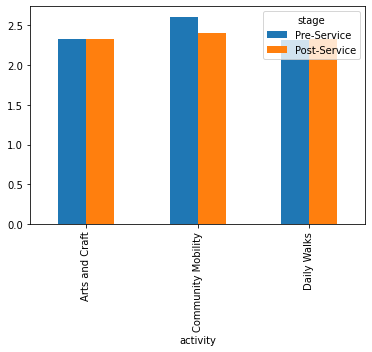

In [105]:
gen_well_summary = gen_well.pivot_table(values = 'rating', index = 'activity', columns = 'stage', aggfunc = 'mean')
gen_well_summary = gen_well_summary[['Pre-Service', 'Post-Service']]

gen_well_summary.plot(kind = 'bar')

# MISO

<AxesSubplot:xlabel='indicator'>

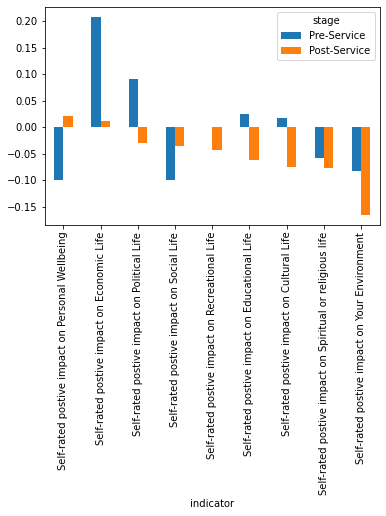

In [106]:
miso_full = report[(report.indicator != 'Goal Progress') & (report.indicator != 'Comments') & (report.indicator != 'Attribution')]

miso_indicators = miso_full.groupby(['id', 'stage', 'indicator']).mean().reset_index()

miso_ungrouped = miso_indicators.pivot_table(values = 'rating', index = 'indicator', columns = 'stage', aggfunc = 'mean')
miso_ungrouped = miso_ungrouped[['Pre-Service', 'Post-Service']]

miso_ungrouped.sort_values('Post-Service', ascending = False).plot(kind = 'bar')

<AxesSubplot:xlabel='activity'>

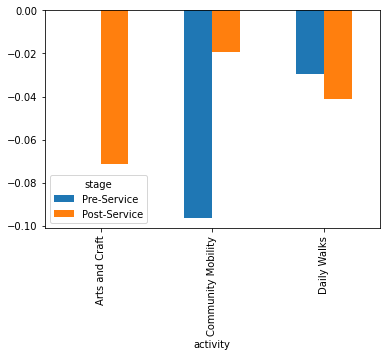

In [107]:
miso_activity = miso_full.groupby(['activity', 'id', 'stage']).aggregate({'rating':'mean'}).reset_index()

miso_summary = miso_activity.pivot_table(values = 'rating', index = 'activity', columns = 'stage', aggfunc = 'mean')
miso_summary = miso_summary[['Pre-Service', 'Post-Service']]

miso_summary.plot(kind = 'bar')

# Regression

## MISO Indicators

In [108]:
miso_indicators.head()

,id,stage,indicator,rating
0,0032v00003U0Uwo,Post-Service,Self-rated postive impact on Cultural Life,0.5
1,0032v00003U0Uwo,Post-Service,Self-rated postive impact on Economic Life,1.0
2,0032v00003U0Uwo,Post-Service,Self-rated postive impact on Educational Life,1.0
3,0032v00003U0Uwo,Post-Service,Self-rated postive impact on Personal Wellbeing,0.0
4,0032v00003U0Uwo,Post-Service,Self-rated postive impact on Political Life,-1.0


In [130]:
import statsmodels.api as sm
import numpy as np

# No base category/constant regression - coefficients are the means for each indicator at the pre and post-service stages

dummies = pd.get_dummies(miso_indicators.indicator)
df = miso_indicators.drop(columns = 'indicator')
df = pd.concat([df, dummies], axis = 1)

df['stage'] = df[['stage']].replace({'Pre-Service' : 0, 'Post-Service': 1})

X = pd.DataFrame()

for i in range(3, len(df.columns)):
    X[df.columns[i]] = df.iloc[:,i]
    X[df.columns[i] + " at Post-Service stage"] = df.iloc[:, i] * df.stage

y = df.rating

# Database of interacative and base variables
X.head()

,Self-rated postive impact on Cultural Life,Self-rated postive impact on Cultural Life at Post-Service stage,Self-rated postive impact on Economic Life,Self-rated postive impact on Economic Life at Post-Service stage,Self-rated postive impact on Educational Life,Self-rated postive impact on Educational Life at Post-Service stage,Self-rated postive impact on Personal Wellbeing,Self-rated postive impact on Personal Wellbeing at Post-Service stage,Self-rated postive impact on Political Life,Self-rated postive impact on Political Life at Post-Service stage,Self-rated postive impact on Recreational Life,Self-rated postive impact on Recreational Life at Post-Service stage,Self-rated postive impact on Social Life,Self-rated postive impact on Social Life at Post-Service stage,Self-rated postive impact on Spiritual or religious life,Self-rated postive impact on Spiritual or religious life at Post-Service stage,Self-rated postive impact on Your Environment,Self-rated postive impact on Your Environment at Post-Service stage
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [131]:
est = sm.OLS(y, X)
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7419
Date:                Wed, 10 Nov 2021   Prob (F-statistic):              0.760
Time:                        09:04:23   Log-Likelihood:                -537.14
No. Observations:                 711   AIC:                             1110.
Df Residuals:                     693   BIC:                             1192.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

### Insights

- Coefficients for *at Post-Service stage* variables indicate the change in the mean from the pre-service stage. Their t-values indicate the significance of the change.
- Thereotically, no result should be statistically significant due to the intentional randomness in the data
- The significance of *impact on economic life* at the 10% is then an instance of Type 1 error.

## MISO Activities

In [13]:
miso_activity.head()

,activity,id,stage,rating
0,Arts and Craft,0032v00003U0V3g,Post-Service,0.000000
1,Arts and Craft,0032v00003U0V3i,Post-Service,0.111111
2,Arts and Craft,0032v00003U0V3i,Pre-Service,0.444444
3,Arts and Craft,0032v00003U0V3n,Post-Service,0.111111
4,Arts and Craft,0032v00003U0V43,Post-Service,0.111111


In [132]:
# No base category/constant regression - coefficients are the means for each activity at the pre and post-service stages

dummies = pd.get_dummies(miso_activity.activity)
df = miso_activity.drop(columns = 'activity')
df = pd.concat([df, dummies], axis = 1)

df['stage'] = df[['stage']].replace({'Pre-Service' : 0, 'Post-Service': 1})

X = pd.DataFrame()

for i in range(3, len(df.columns)):
    X[df.columns[i]] = df.iloc[:,i]
    X[df.columns[i] + " at Post-Service stage"] = df.iloc[:, i] * df.stage

y = df.rating

# Database of interacative and base variables
X.head()

,Arts and Craft,Arts and Craft at Post-Service stage,Community Mobility,Community Mobility at Post-Service stage,Daily Walks,Daily Walks at Post-Service stage
0,1,1,0,0,0,0
1,1,1,0,0,0,0
2,1,0,0,0,0,0
3,1,1,0,0,0,0
4,1,1,0,0,0,0


In [133]:
est = sm.OLS(y, X)
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.4698
Date:                Wed, 10 Nov 2021   Prob (F-statistic):              0.799
Time:                        09:09:29   Log-Likelihood:                -9.7879
No. Observations:                 215   AIC:                             31.58
Df Residuals:                     209   BIC:                             51.80
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## General Wellbeing Activities

In [14]:
gen_well.head()

,activity,id,stage,rating
0,Arts and Craft,0032v00003U0Uwo,Post-Service,3.0
1,Arts and Craft,0032v00003U0Uwo,Pre-Service,3.0
2,Arts and Craft,0032v00003U0V3g,Post-Service,3.0
3,Arts and Craft,0032v00003U0V3g,Pre-Service,2.0
4,Arts and Craft,0032v00003U0V3i,Post-Service,3.0


In [136]:
# No base category/constant regression - coefficients are the means for each activity at the pre and post-service stages

dummies = pd.get_dummies(gen_well.activity)
df = gen_well.drop(columns = 'activity')
df = pd.concat([df, dummies], axis = 1)

df['stage'] = df[['stage']].replace({'Pre-Service' : 0, 'Post-Service': 1})

X = pd.DataFrame()

for i in range(3, len(df.columns)):
    X[df.columns[i]] = df.iloc[:,i]
    X[df.columns[i] + " at Post-Service stage"] = df.iloc[:, i] * df.stage

y = df.rating

# Database of interacative and base variables
X.head()

,Arts and Craft,Arts and Craft at Post-Service stage,Community Mobility,Community Mobility at Post-Service stage,Daily Walks,Daily Walks at Post-Service stage
0,1,1,0,0,0,0
1,1,0,0,0,0,0
2,1,1,0,0,0,0
3,1,0,0,0,0,0
4,1,1,0,0,0,0


In [137]:
est = sm.OLS(y, X)
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2614
Date:                Wed, 10 Nov 2021   Prob (F-statistic):              0.934
Time:                        09:10:32   Log-Likelihood:                -629.39
No. Observations:                 331   AIC:                             1271.
Df Residuals:                     325   BIC:                             1294.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------